In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Load the cifar10 dataset

In [2]:
from tensorflow.keras.datasets import cifar10

In [3]:
# Load the CIFAR-10 dataset

(training_features, training_labels), (test_features, test_labels) = cifar10.load_data()

In [4]:
# Convert the labels to a one-hot encoding

num_classes = 10

training_labels = tf.keras.utils.to_categorical(training_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [5]:
training_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### Create a generator function

In [6]:
# Create a function that returns a data generator

def get_generator(features, labels, batch_size=1):
    for n in range(int(len(features)/batch_size)):
        yield (features[n*batch_size:(n+1)*batch_size], labels[n*batch_size:(n+1)*batch_size])

In [7]:
# Use the function we created to get a training data generator with a batch size of 1

training_generator = get_generator(training_features, training_labels)

In [8]:
# Access the shape of the items generated by training_generator using the 'next' function to yield an item

image, label = next(training_generator)
print(image.shape)
print(label.shape)

(1, 32, 32, 3)
(1, 10)


[9]


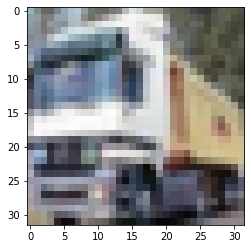

In [9]:
# Test the training generator by otaining an image using the 'next' generator function, and then using imshow to plot it
# Print the corresponding label

image,label = next(training_generator)
plt.imshow(image.squeeze(0))
print(label.argmax(1))

In [10]:
# Reset the generator by re-running the 'get_generator' function.

train_generator = get_generator(training_features, training_labels)

### Create a data augmentation generator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Create a function to convert an image to monochrome

def monochrome(x):
    def func_bw(a):
        average_color = np.mean(a)
        return [average_color, average_color, average_color]
    x = np.apply_along_axis(func_bw, -1, x)
    return x

In [13]:
# Create an ImageDataGenerator object

image_generator = ImageDataGenerator(preprocessing_function=monochrome,
                                    rotation_range=180,
                                    rescale=(1/255.))

image_generator.fit(training_features)

In [14]:
# Create an iterable generator using the 'flow' function

image_generator_iterable = image_generator.flow(training_features, training_labels, batch_size=1, shuffle=False)

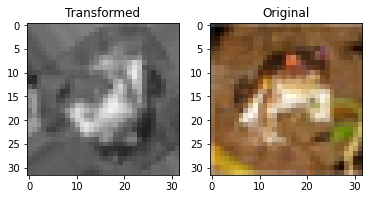

In [15]:
# Show a sample from the generator and compare with the original

image, label = next(image_generator_iterable)
image_orig, label_orig = next(train_generator)
figs, axes = plt.subplots(1,2)
axes[0].imshow(image[0,:,:,:])
axes[0].set_title('Transformed')
axes[1].imshow(image_orig[0,:,:,:])
axes[1].set_title('Original')
plt.show()

### Flow from directory 

data used:
https://www.kaggle.com/alxmamaev/flowers-recognition

In [16]:
# Inspect the directory structure

classes = ! ls data/flowers/

In [17]:
classes = classes[:-1]

In [18]:
classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [19]:
import os
import shutil

In [20]:
# Move 30% of the files to the validation folder

#for class_ in classes:
#    src = 'data/flowers/' + class_
#    dest = 'data/flowers/valid/' + class_
#    src_files = os.listdir(src)

#    i=0
#    size = len(src_files)

#    for file_name in src_files:
#        full_file_name = os.path.join(src, file_name)
#        if os.path.isfile(full_file_name):
#            if i/size < 0.3:
#                shutil.move(full_file_name, dest)
#            else:
#                pass
#            i = i + 1

In [25]:
train_path = 'data/flowers/train'
val_path = 'data/flowers/valid'

In [22]:
# Create an ImageDataGenerator object

datagenerator = ImageDataGenerator(rescale=(1/255.))

In [23]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [24]:
# Create a training data generator

train_generator = datagenerator.flow_from_directory(train_path, batch_size=64, classes=classes, target_size=(16, 16))

Found 2267 images belonging to 5 classes.


In [26]:
# Create a validation data generator

val_generator = datagenerator.flow_from_directory(val_path, batch_size=64, classes=classes, target_size=(16, 16))

Found 976 images belonging to 5 classes.


[1. 0. 0. 0. 0.]


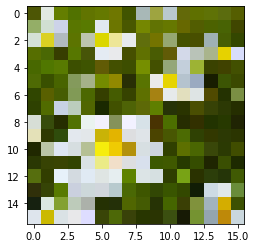

In [30]:
# Get and display an image and label from the training generator

x = next(train_generator)
plt.imshow(x[0][4])
print(x[1][4])

In [31]:
# Reset training generator

train_generator = datagenerator.flow_from_directory(train_path, batch_size=64, classes=classes, target_size=(16, 16))

Found 2267 images belonging to 5 classes.


### Create a model to train

In [32]:
# Build a CNN model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense

model = tf.keras.Sequential()
model.add(Input((16, 16, 3)))
model.add(Conv2D(8, (32, 32), padding='same', activation='relu'))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(8, (8, 8), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(4, (4, 4), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [33]:
# Create an optimizer object

optimizer = tf.keras.optimizers.Adam(1e-3)

In [34]:
# Compile the model

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 8)         24584     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 8)           4104      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 4)           516       
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                2

### Train the model

In [36]:
# Calculate the training generator and test generator steps per epoch

train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = val_generator.n // val_generator.batch_size
print(train_steps_per_epoch, val_steps)

35 15


In [37]:
# Fit the model

model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=5)

Epoch 1/5
35/35 [==============================] - 7s 187ms/step - loss: 1.6046 - accuracy: 0.2090
Epoch 2/5
35/35 [==============================] - 6s 171ms/step - loss: 1.5512 - accuracy: 0.2544
Epoch 3/5
35/35 [==============================] - 6s 171ms/step - loss: 1.4556 - accuracy: 0.3482
Epoch 4/5
35/35 [==============================] - 6s 170ms/step - loss: 1.4237 - accuracy: 0.3808
Epoch 5/5
35/35 [==============================] - 6s 173ms/step - loss: 1.3587 - accuracy: 0.4173


### Evaluate the model

In [38]:
# Evaluate the model

model.evaluate(val_generator, steps=val_steps)

15/15 [==============================] - 3s 171ms/step - loss: 1.3552 - accuracy: 0.4281


[1.3552004098892212, 0.4281249940395355]

### Predict using the generator

In [39]:
# Predict labels with the model

predictions = model.predict(val_generator, steps=1)

In [40]:
print(np.round(predictions, 2))

[[0.06 0.29 0.14 0.27 0.24]
 [0.08 0.23 0.22 0.13 0.34]
 [0.06 0.27 0.16 0.19 0.32]
 [0.12 0.23 0.03 0.56 0.07]
 [0.51 0.11 0.14 0.06 0.17]
 [0.   0.23 0.01 0.72 0.04]
 [0.38 0.17 0.12 0.13 0.19]
 [0.09 0.14 0.36 0.04 0.37]
 [0.26 0.19 0.22 0.13 0.21]
 [0.06 0.15 0.39 0.05 0.35]
 [0.03 0.13 0.45 0.03 0.36]
 [0.11 0.26 0.04 0.5  0.1 ]
 [0.16 0.21 0.22 0.13 0.29]
 [0.04 0.18 0.35 0.06 0.37]
 [0.14 0.27 0.1  0.32 0.18]
 [0.02 0.32 0.11 0.28 0.27]
 [0.15 0.26 0.06 0.43 0.11]
 [0.24 0.19 0.22 0.11 0.24]
 [0.14 0.25 0.15 0.19 0.27]
 [0.02 0.24 0.02 0.67 0.05]
 [0.25 0.12 0.32 0.04 0.27]
 [0.03 0.25 0.03 0.63 0.07]
 [0.42 0.13 0.18 0.07 0.19]
 [0.16 0.18 0.3  0.08 0.28]
 [0.03 0.21 0.27 0.08 0.42]
 [0.   0.25 0.02 0.67 0.05]
 [0.08 0.12 0.44 0.03 0.32]
 [0.35 0.11 0.29 0.04 0.22]
 [0.36 0.15 0.19 0.08 0.21]
 [0.25 0.22 0.1  0.3  0.13]
 [0.04 0.3  0.13 0.26 0.26]
 [0.03 0.06 0.6  0.01 0.3 ]
 [0.09 0.26 0.05 0.51 0.09]
 [0.02 0.26 0.02 0.62 0.08]
 [0.08 0.27 0.05 0.5  0.1 ]
 [0.04 0.1  0.51 0.0